### Implementing a research paper techniques for n-gram language modeling
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf


Curse of dimentionality-- When the vocabulary size is large (e.g., millions of tokens), the output layer of the language model needs to predict the probability distribution over all possible tokens in the vocabulary. This means that the model has to estimate probabilities for a large number of classes, which can make training more challenging.


The function has parameters that can be iteratively tuned in order to maximize the log-likehood of the training data.

<!-- Architecture of the model:
3 words input -> embeddings -> MLP -> 1 word prediction -->

<!-- Regularization techniques used: -->
<!-- - Weight decay -->

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(".".join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {c:i for i,c in stoi.items()}

In [3]:
# Build dataset

def build_dataset(n, data, splits):
  X, Y = [], []
  for w in data:
    padding = [0]*n
    for ch in w + '.':
      ix = stoi[ch]
      X.append(padding)
      Y.append(ix)
      padding = padding[1:] + [ix] #sliding window
  X,Y = torch.tensor(X),torch.tensor(Y)
  tr, va, te = splits
  tr = int(X.shape[0]*0.8)
  va = int(X.shape[0]*0.1)

  xtrain, ytrain = X[:tr], Y[:tr]
  xvalid, yvalid = X[tr:tr+va], Y[tr:tr+va]
  xtest, ytest = X[tr+va:], Y[tr+va:]
  return [xtrain, ytrain, xvalid, yvalid, xtest, ytest]

xtrain, ytrain, xvalid, yvalid, xtest, ytest = build_dataset(n=3, data=words, splits=(0.8, 0.1, 0.1))

In [4]:
# Hyperparameters
n = 3 # trigram model
emb_sz = 10
n_hidden = 200
vocab_sz = len(chars) # it's 27

# --------------------------------------------------

# embedding matrix -> Hidden layer -> output layer
C  = torch.rand(vocab_sz, emb_sz)
w1 = torch.rand(n*emb_sz, n_hidden)
b1 = torch.rand(n_hidden) 
w2 = torch.rand(n_hidden, vocab_sz)
b2 = torch.rand(vocab_sz)

# Setting up gradient requirements
parameters = [C, w1, b1, w2, b2]
for p in parameters:
  p.requires_grad = True

In [5]:
sum([p.nelement() for p in parameters]) # number of neurons (good to know)

11897

In [6]:
# finding a good learning rate

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [7]:
# finding LR
lri = []
lossi = []
perpi = []
stepi = []
epoch = 1000
bs = 32 # batch sz

for i in range(epoch):
  idx = torch.randint(0, xtrain.shape[0], size=(bs,))

  # forward
  emb = C[xtrain[idx]]
  h = torch.tanh(emb.view(emb.shape[0], -1) @ w1 + b1)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, ytrain[idx])

  # backward
  for p in parameters: 
    p.grad = None
  loss.backward()
  perplexity = torch.exp(loss)
  lr = lrs[i] # to find lr, we change it everytime and plot

  # step
  for p in parameters:
    p.data -= p.grad.data * lr

  # track
  lri.append(lr)
  stepi.append(i)
  lossi.append(loss.log10().item())
  perpi.append(perplexity.item())

  if i%10000 == 0:
    print(f"epoch: {i:7d}/{epoch:7d} | loss: {loss.item():.4f} | perplexity: {perplexity.item():.4f}")

epoch:       0/   1000 | loss: 7.4537 | perplexity: 1726.2468


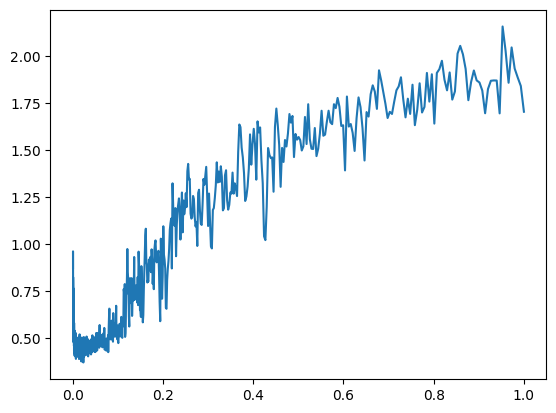

In [8]:
plt.plot(lri, lossi)

0.1 has low loss compared to other LRs

In [9]:
##### Reinit

# Hyperparameters
n = 3 # trigram model
emb_sz = 10
n_hidden = 200
vocab_sz = len(chars) # it's 27

# --------------------------------------------------

# embedding matrix -> Hidden layer -> output layer
C  = torch.rand(vocab_sz, emb_sz)
w1 = torch.rand(n*emb_sz, n_hidden)
b1 = torch.rand(n_hidden) 
w2 = torch.rand(n_hidden, vocab_sz)
b2 = torch.rand(vocab_sz)

# Setting up gradient requirements
parameters = [C, w1, b1, w2, b2]
for p in parameters:
  p.requires_grad = True

lossi = []
perpi = []

In [10]:
epoch = 200_000
bs = 32 # batch sz
wd = 0.01 # weight decay

for i in range(epoch):
  idx = torch.randint(0, xtrain.shape[0], size=(bs,))

  emb = C[xtrain[idx]]
  h = torch.tanh(emb.view(emb.shape[0], -1) @ w1 + b1)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, ytrain[idx])

  for p in parameters: 
    p.grad = None
  loss.backward()
  perplexity = torch.exp(loss)

  lr = 0.01 if i < 100_000 else 0.001

  # if i < epoch:
  for p in parameters:
    p.data -= p.grad.data * lr
  # else:
  #   for p in parameters:
  #     p.grad += 2*p.data*wd
  #     p.data -= p.grad.data * lr

  # track
  lossi.append(loss.log10().item())
  perpi.append(perplexity.item())

  if i%10000 == 0:
    print(f"epoch: {i:7d}/{epoch:7d} | loss: {loss.item():.4f} | perplexity: {perplexity.item():.4f}")

epoch:       0/ 200000 | loss: 10.8386 | perplexity: 50951.4648
epoch:   10000/ 200000 | loss: 3.2470 | perplexity: 25.7132
epoch:   20000/ 200000 | loss: 2.7534 | perplexity: 15.6961
epoch:   30000/ 200000 | loss: 2.9428 | perplexity: 18.9692
epoch:   40000/ 200000 | loss: 2.7551 | perplexity: 15.7222
epoch:   50000/ 200000 | loss: 2.6377 | perplexity: 13.9811
epoch:   60000/ 200000 | loss: 3.0233 | perplexity: 20.5590
epoch:   70000/ 200000 | loss: 3.0532 | perplexity: 21.1829
epoch:   80000/ 200000 | loss: 2.7362 | perplexity: 15.4288
epoch:   90000/ 200000 | loss: 2.4028 | perplexity: 11.0543
epoch:  100000/ 200000 | loss: 2.4950 | perplexity: 12.1218
epoch:  110000/ 200000 | loss: 2.5083 | perplexity: 12.2842
epoch:  120000/ 200000 | loss: 2.6895 | perplexity: 14.7244
epoch:  130000/ 200000 | loss: 2.5394 | perplexity: 12.6724
epoch:  140000/ 200000 | loss: 2.6495 | perplexity: 14.1476
epoch:  150000/ 200000 | loss: 2.6520 | perplexity: 14.1822
epoch:  160000/ 200000 | loss: 2.530

In [11]:
# train loss
emb = C[xtrain]
h = torch.tanh(emb.view(xtrain.shape[0], -1) @ w1 + b1)
logits = h@w2 + b2
loss = F.cross_entropy(logits, ytrain)
print(f"train loss: {loss.item()}")

# valid loss
emb = C[xvalid]
h = torch.tanh(emb.view(xvalid.shape[0], -1) @ w1 + b1)
logits = h@w2 + b2
loss = F.cross_entropy(logits, yvalid)
print(f"valid loss: {loss.item()}")

train loss: 2.5715243816375732
valid loss: 2.705125093460083


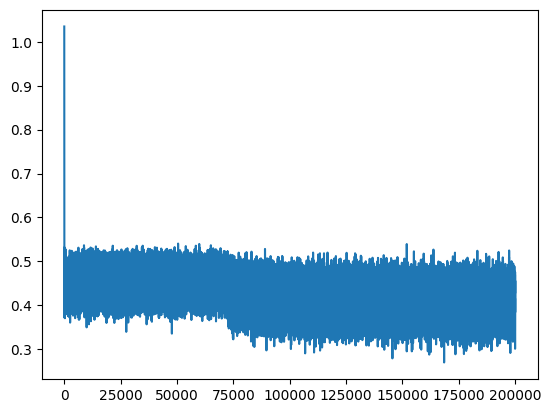

In [12]:
plt.plot(lossi)

In [ ]:
# plt.ylim(0,5)
# plt.xlim(0.0022222,0.15555)
plt.plot(lri, lossi)

# less noise at 0.08

In [14]:
# Sampling from the model
with torch.no_grad():

  for _ in range(10):
    out = []
    padding = [0]*n

    while True:
      emb = C[torch.tensor([padding])]
      h = torch.tanh(emb.view(1, -1)@w1 + b1)
      logits = torch.softmax(h@w2 + b2, dim=1)
      idx = torch.multinomial(logits, num_samples=1 ,replacement=True).item()
      padding = padding[1:] + [idx]
      out.append(idx)
      if idx == 0: break

    print("".join(itos[o] for o in out))

chherelth.
saravdany.
brrlhcshilrn.
hayi.
amriniotin.
aer.
ayn.
jodx.
larlinaemusehat.
ell.


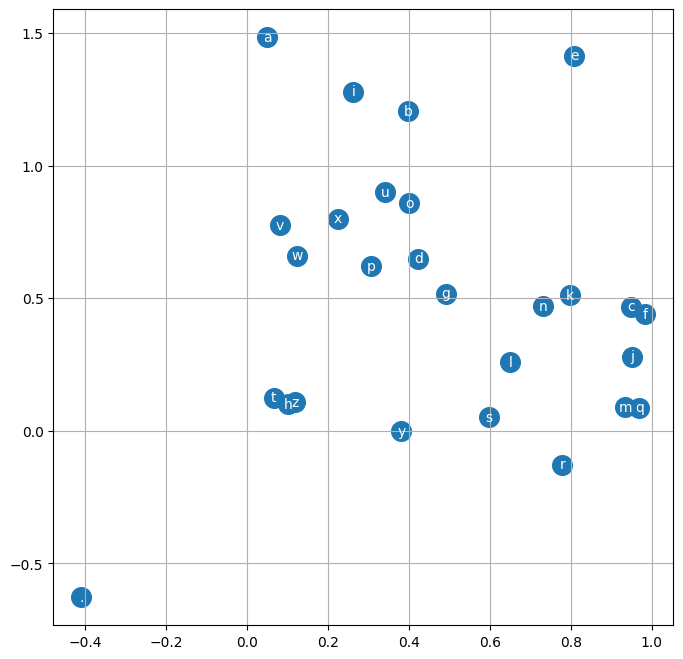

In [15]:
# visualizing the embedding for emb_sz=2 (growing emb_sz makes it hard to visualize)
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')